In [2]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

In [4]:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, noise
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit.library import XGate, ZGate
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# ----------------------------------------------------
# 🔹 Helper: Build teleportation circuit
# ----------------------------------------------------
def build_teleportation_circuit(theta, phi, use_classical=True):
    qc = QuantumCircuit(3, 2)

    # 1️⃣ Prepare arbitrary input state |ψ⟩ on qubit 0
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_initial = Statevector.from_instruction(qc)

    # 2️⃣ Create Bell pair (qubits 1,2)
    qc.h(1)
    qc.cx(1, 2)

    # 3️⃣ Bell measurement
    qc.cx(0, 1)
    qc.h(0)

    if use_classical:
        # Measure and use classical corrections
        qc.measure(0, 0)
        qc.measure(1, 1)
        qc.x(2).c_if(qc.cregs[0], 1)     # conditional on bit 1
        qc.z(2).c_if(qc.cregs[0], 2)     # conditional on bit 0
    else:
        # Coherent corrections (no measurement)
        qc.cx(1, 2)
        qc.cz(0, 2)

    return qc, sv_initial



Bloch vector for θ=0.79, φ=0.79


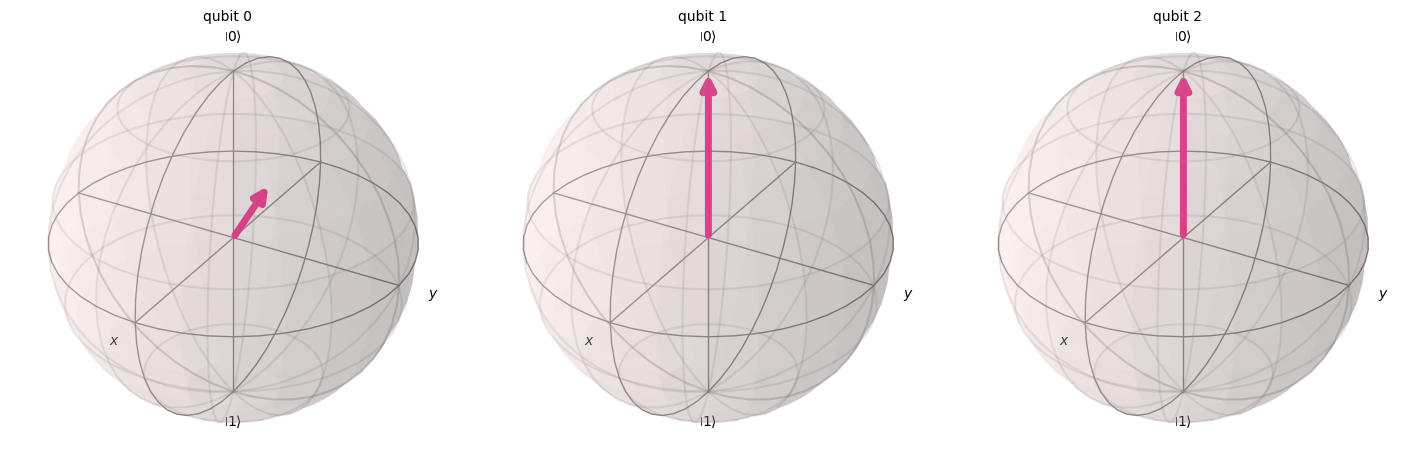

Bloch vector for θ=1.57, φ=1.05


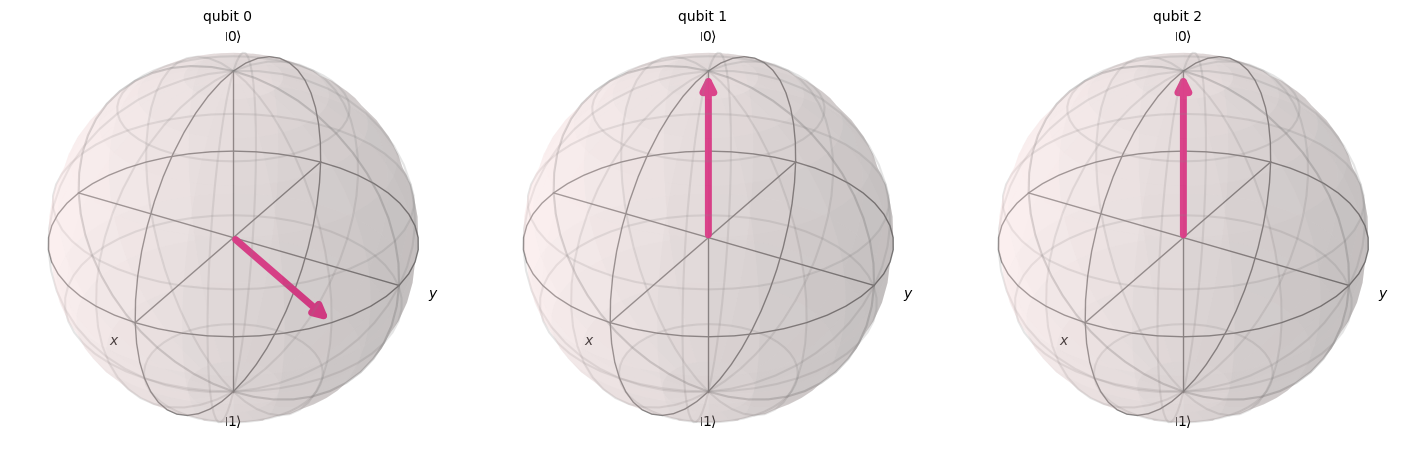

Bloch vector for θ=1.05, φ=0.52


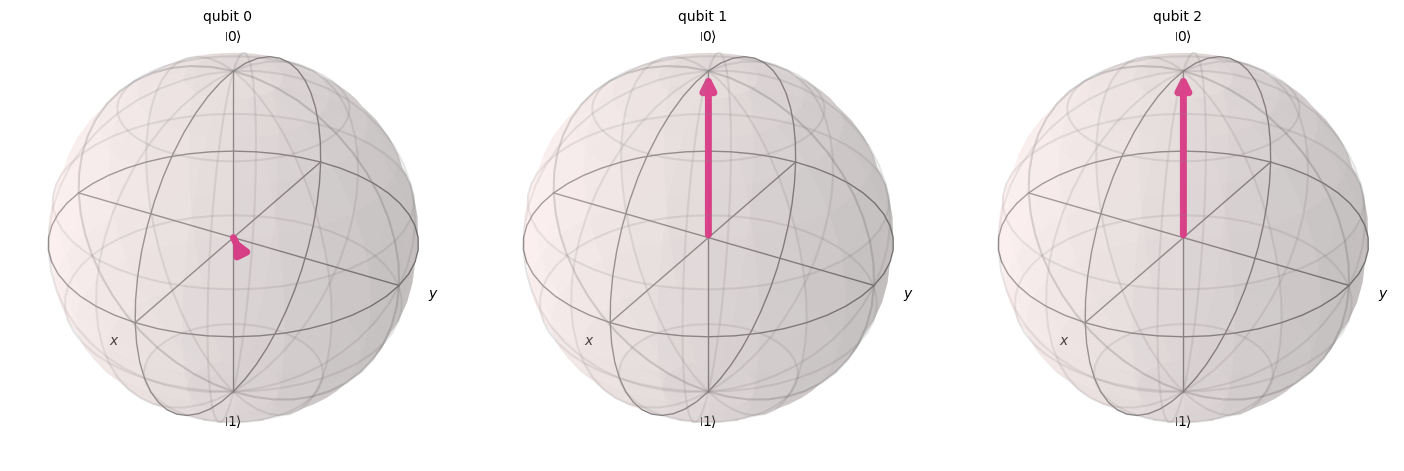

In [6]:

angles = [(np.pi/4, np.pi/4), (np.pi/2, np.pi/3), (np.pi/3, np.pi/6)]
for theta, phi in angles:
    qc, sv_init = build_teleportation_circuit(theta, phi, use_classical=False)
    print(f"Bloch vector for θ={theta:.2f}, φ={phi:.2f}")
    display(plot_bloch_multivector(sv_init))

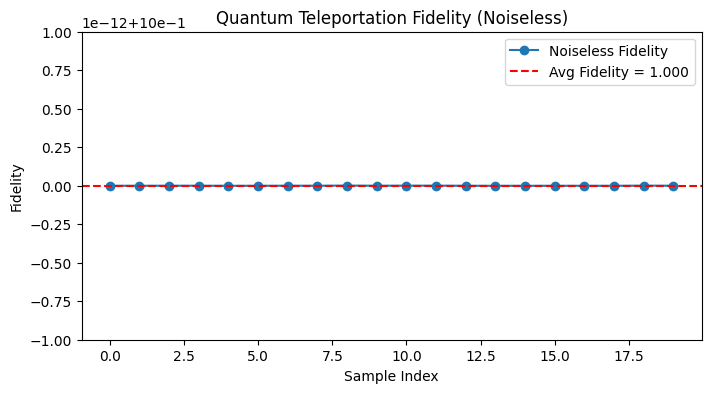

In [7]:
def teleport_and_fidelity(theta, phi, noisy=False, noise_model=None):
    qc, sv_initial = build_teleportation_circuit(theta, phi, use_classical=False)
    sim = AerSimulator(noise_model=noise_model) if noisy else AerSimulator()
    qc.save_statevector()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    sv_final = Statevector(result.data(0)['statevector'])
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])

    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]
    fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
    return fidelity

# Run for 20 random (θ, φ)
num_samples = 20
fidelities = []
for _ in range(num_samples):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)
    fidelities.append(teleport_and_fidelity(theta, phi))

plt.figure(figsize=(8,4))
plt.plot(range(num_samples), fidelities, 'o-', label='Noiseless Fidelity')
plt.axhline(np.mean(fidelities), color='red', linestyle='--', label=f'Avg Fidelity = {np.mean(fidelities):.3f}')
plt.xlabel("Sample Index")
plt.ylabel("Fidelity")
plt.title("Quantum Teleportation Fidelity (Noiseless)")
plt.legend()
plt.show()




Step 1️⃣ Initial state on Q0:


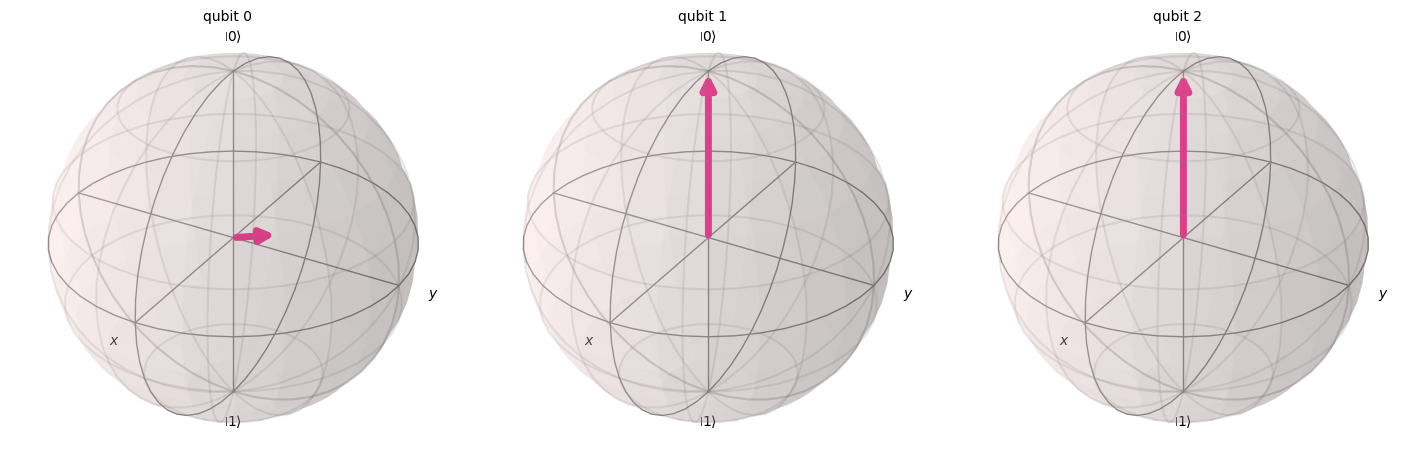

Step 2️⃣ After H on Q1 (Bell prep):


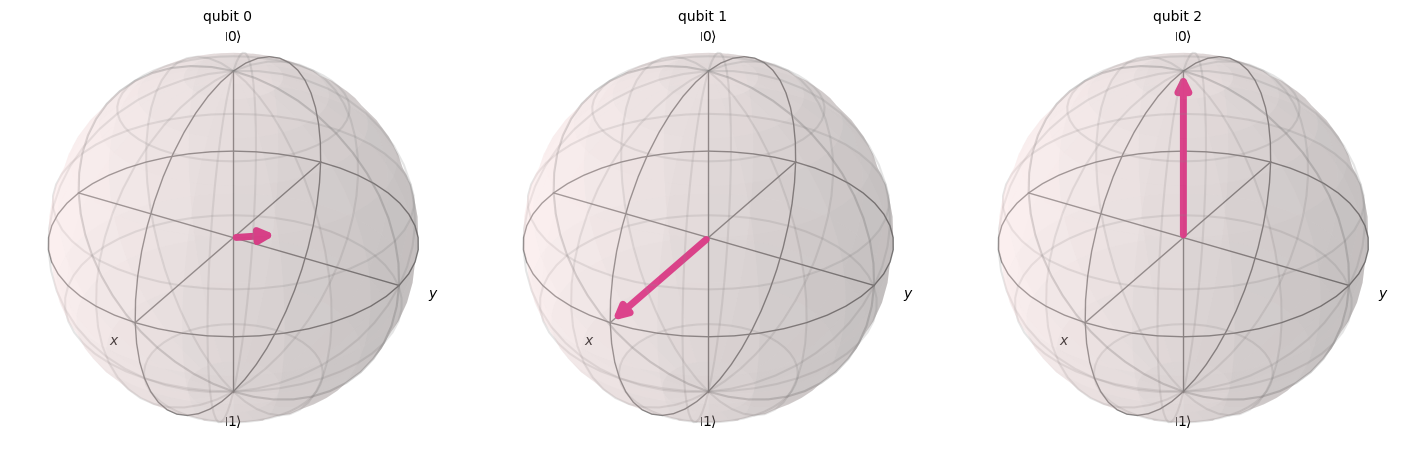

Step 3️⃣ After CX(1→2):


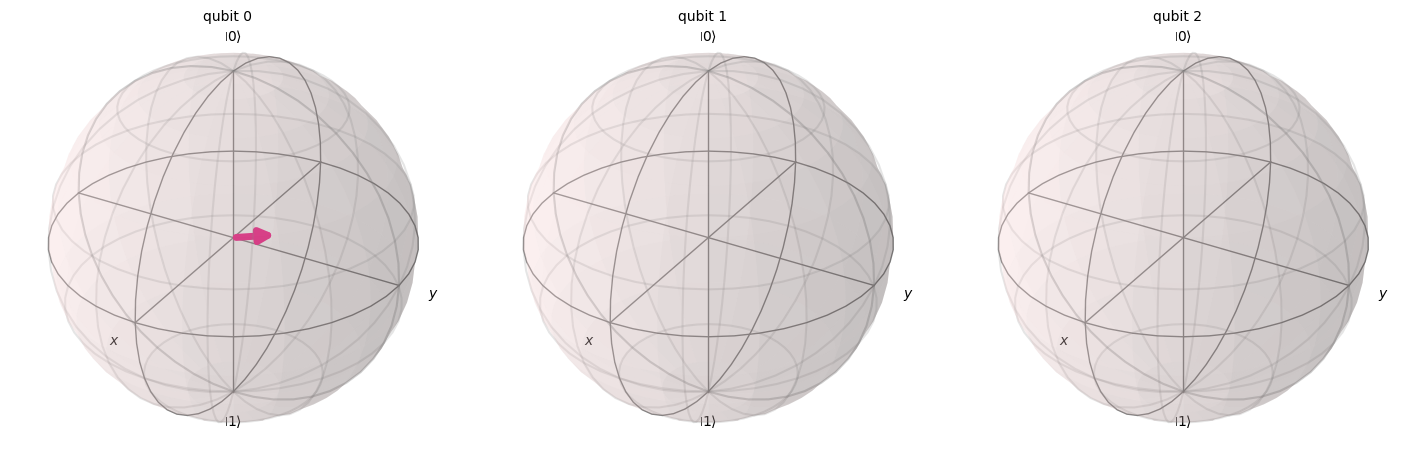

Step 4️⃣ After Teleportation:


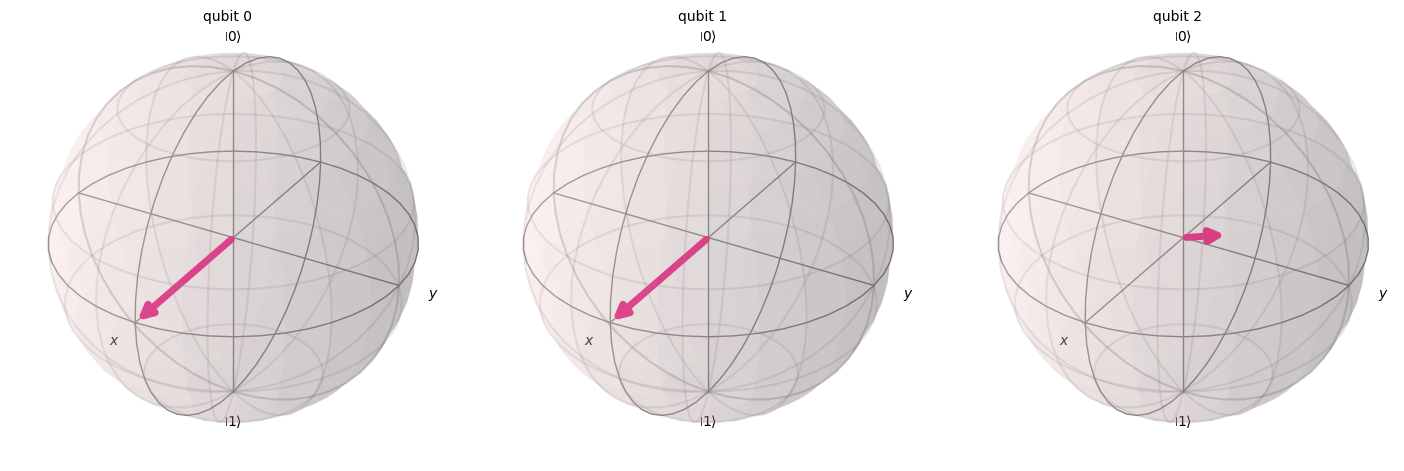

In [8]:

theta, phi = np.pi/3, np.pi/4
qc_vis = QuantumCircuit(3)
qc_vis.ry(theta, 0)
qc_vis.rz(phi, 0)
print("\nStep 1️⃣ Initial state on Q0:")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.h(1)
print("Step 2️⃣ After H on Q1 (Bell prep):")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.cx(1, 2)
print("Step 3️⃣ After CX(1→2):")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))

qc_vis.cx(0, 1)
qc_vis.h(0)
qc_vis.cx(1, 2)
qc_vis.cz(0, 2)
print("Step 4️⃣ After Teleportation:")
display(plot_bloch_multivector(Statevector.from_instruction(qc_vis)))


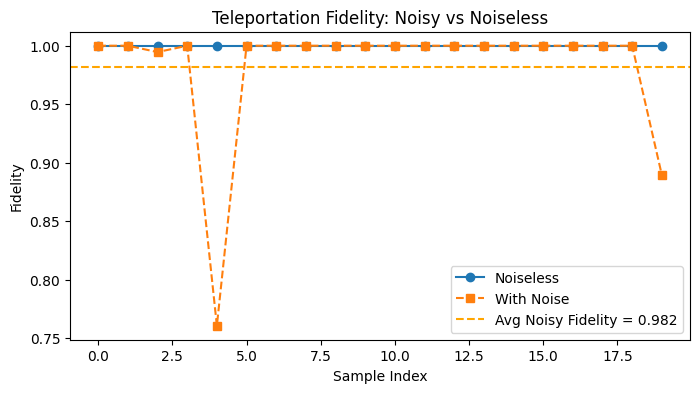


Average Noiseless Fidelity: 1.0000
Average Noisy Fidelity:     0.9822


In [9]:
error1 = noise.depolarizing_error(0.02, 1)
error2 = noise.depolarizing_error(0.04, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error1, ['rz','ry','h','x','z'])
noise_model.add_all_qubit_quantum_error(error2, ['cx'])

# Compare fidelity with and without noise
fidelities_noisy = [teleport_and_fidelity(np.random.uniform(0,np.pi),
                                          np.random.uniform(0,2*np.pi),
                                          noisy=True,
                                          noise_model=noise_model)
                    for _ in range(num_samples)]

plt.figure(figsize=(8,4))
plt.plot(range(num_samples), fidelities, 'o-', label='Noiseless')
plt.plot(range(num_samples), fidelities_noisy, 's--', label='With Noise')
plt.axhline(np.mean(fidelities_noisy), color='orange', linestyle='--', label=f'Avg Noisy Fidelity = {np.mean(fidelities_noisy):.3f}')
plt.xlabel("Sample Index")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity: Noisy vs Noiseless")
plt.legend()
plt.show()

print(f"\nAverage Noiseless Fidelity: {np.mean(fidelities):.4f}")
print(f"Average Noisy Fidelity:     {np.mean(fidelities_noisy):.4f}")